# Installs

In [0]:
! pip install -q git+https://github.com/fastai/fastcore
! pip install -q git+https://github.com/fastai/fastai2
! pip install -q git+https://github.com/thomasbrandon/mish-cuda
! pip install -q neptune-client
! git clone https://github.com/pgmmpk/tfrecord.git
! pip install -q kornia

# Imports

In [0]:
%tensorflow_version 1.x
from fastai2.vision.all import *
import tensorflow as tf
from tfrecord.tfrecord import *
from mish_cuda import MishCuda
import kornia
import gc

TensorFlow 1.x selected.



# Setup Dataloader

In [0]:
path = Path('flowers/tfrecords-jpeg-224x224')

train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

In [0]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

In [0]:
data = []
for name in train_fnames+test_fnames:
  r = Reader(str(name), unpack_sample)
  for sample in r:
    data.append([sample['image'][0], sample['class'][0]])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [0]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

splitter = IndexSplitter(range(12753, len(data)))

def get_items(*args, **kwargs): return data

# Submission 1 
## (24,32,64) stem, sa=True, vertical flip MaxBlurPool
Stem from [Ross Wightman](https://github.com/rwightman) on Twitter.

In [0]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
def replace_model_layer(model, layer_type_old, new_layer):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = replace_model_layer(module, layer_type_old, new_layer)

        if type(module) == layer_type_old:
            layer_old = module
            model._modules[name] = new_layer

    return model

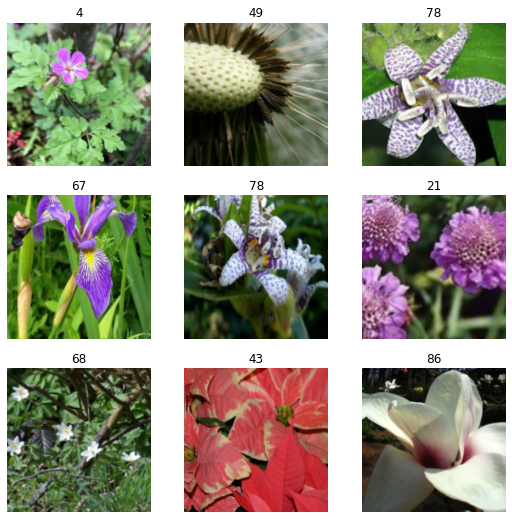

In [0]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[RandomResizedCrop(224, min_scale=0.7)],
                  batch_tfms=[*aug_transforms(do_flip=True)])

dls = block.dataloaders([''], bs=64)

dls.show_batch()

In [0]:
model = xse_resnext50(pretrained=False, act_cls=MishCuda, sa=True, n_out=dls.c, stem_szs=(24,32,64))
model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))

In [0]:
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

SuggestedLRs(lr_min=0.0016795642673969268, lr_steep=0.005705171264708042)

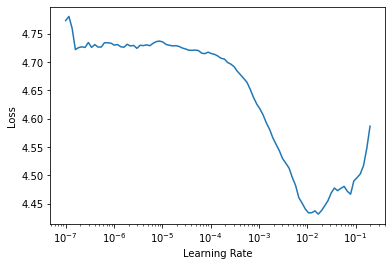

In [0]:
learn.lr_find(end_lr=5e-1)

In [0]:
results = []
for i in range(3):
    model = xse_resnext50(pretrained=False, act_cls=MishCuda, sa=True, n_out=dls.c, stem_szs=(24,32,64))
    model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

epoch,train_loss,valid_loss,accuracy,time
0,3.232070,3.170562,0.307920,04:49
1,2.746595,2.665204,0.424838,04:46
2,2.410212,2.694193,0.412716,04:50
3,2.155078,2.296811,0.550647,04:49
4,1.752487,1.751578,0.737608,04:47


epoch,train_loss,valid_loss,accuracy,time
0,3.230035,2.903814,0.360183,04:50
1,2.718935,2.736242,0.424030,04:51
2,2.386093,2.644071,0.444504,04:49
3,2.084685,2.358329,0.569235,04:52
4,1.686754,1.684727,0.758890,04:56


epoch,train_loss,valid_loss,accuracy,time
0,3.172785,2.941990,0.343750,04:52
1,2.644308,2.738283,0.443427,04:54
2,2.364609,2.486664,0.524246,04:53
3,2.066896,2.172157,0.595366,04:54
4,1.669561,1.683542,0.762123,05:00


In [0]:
print(results)

[0.7376077771186829, 0.7588900923728943, 0.7621228694915771]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.75287
Accuracy Std: 0.01087


# Submission 2
## (24,32,64) stem, sa=True, vertical flip MaxBlurPool GeM

Stem from [Ross Wightman](https://github.com/rwightman) on Twitter, GeM pool from Kaggle discussion by [DrHB](https://github.com/DrHB).

In [0]:
# GeM Pool from https://github.com/filipradenovic/cnnimageretrieval-pytorch
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [0]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
def replace_model_layer(model, layer_type_old, new_layer):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = replace_model_layer(module, layer_type_old, new_layer)

        if type(module) == layer_type_old:
            layer_old = module
            model._modules[name] = new_layer

    return model

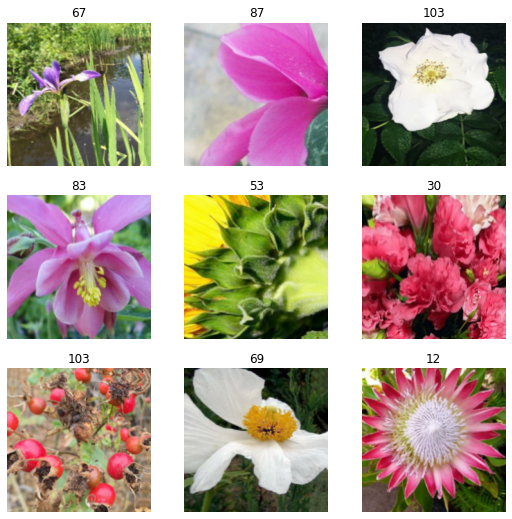

In [0]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[RandomResizedCrop(224, min_scale=0.7)],
                  batch_tfms=[*aug_transforms(do_flip=True)])

dls = block.dataloaders([''], bs=56)

dls.show_batch()

In [0]:
model = xse_resnext50(pretrained=False, act_cls=MishCuda, sa=True, n_out=dls.c, stem_szs=(24,32,64))
model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())

In [0]:
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

SuggestedLRs(lr_min=0.0019596852362155914, lr_steep=0.0006582834175787866)

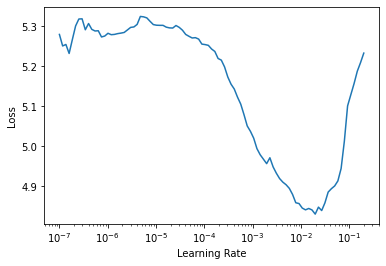

In [0]:
learn.lr_find(end_lr=5e-1)

In [0]:
results = []
for i in range(3):
    if i > 0:
        learn, model = None, None
        gc.collect()
    model = xse_resnext50(pretrained=False, act_cls=MishCuda, sa=True, n_out=dls.c, stem_szs=(24,32,64))
    model = replace_model_layer(model, nn.MaxPool2d, kornia.contrib.MaxBlurPool2d(3, True))
    model = replace_model_layer(model, nn.AdaptiveAvgPool2d, GeM())
    
    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

epoch,train_loss,valid_loss,accuracy,time
0,3.230737,4.577912,0.191541,04:34
1,2.694986,2.938585,0.358028,04:31
2,2.285615,2.309408,0.546606,04:28
3,2.046983,1.941161,0.663254,04:24
4,1.602315,1.634174,0.768588,04:24


epoch,train_loss,valid_loss,accuracy,time
0,3.187274,3.260294,0.280172,04:19
1,2.644847,2.732880,0.424300,04:26
2,2.304841,2.476017,0.492996,04:38
3,2.070295,2.023112,0.639278,04:44
4,1.640551,1.669466,0.762392,05:09


epoch,train_loss,valid_loss,accuracy,time
0,3.281698,3.240268,0.277209,04:49
1,2.711762,3.010204,0.366379,04:55
2,2.360984,2.435090,0.506735,04:53
3,2.091432,1.993925,0.654634,04:58
4,1.669414,1.662552,0.765625,04:48


In [0]:
print(results)

[0.7685883641242981, 0.7623922228813171, 0.765625]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.76554
Accuracy Std: 0.00253
